In [2]:
import netCDF4 as nc
import numpy as np

# Load the data for both years
#data_2020 = nc.Dataset('/Users/heyj/Desktop/sql project/2020data.nc')
#data_2021 = nc.Dataset('/Users/heyj/Desktop/sql project/2020data.nc')
data_2020 = nc.Dataset('2020data.nc')
data_2021 = nc.Dataset('2021data.nc')

# Combine data from both years
z_combined = np.concatenate((data_2020['z'][:], data_2021['z'][:]), axis=0)
u_combined = np.concatenate((data_2020['u'][:], data_2021['u'][:]), axis=0)
v_combined = np.concatenate((data_2020['v'][:], data_2021['v'][:]), axis=0)


In [3]:
# Preprocessing the data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()

z_normalized = scaler.fit_transform(z_combined.reshape(-1, 1)).reshape(z_combined.shape)
u_normalized = scaler.fit_transform(u_combined.reshape(-1, 1)).reshape(u_combined.shape)
v_normalized = scaler.fit_transform(v_combined.reshape(-1, 1)).reshape(v_combined.shape)

# Combine the parameters to form a single dataset
data_combined = np.stack((z_normalized, u_normalized, v_normalized), axis=-1)

# Pad the data to get even dimensions
padded_data = np.pad(data_combined, ((0, 0), (0, 1), (0, 1), (0, 1), (0, 0)), mode='constant')

# Split the data into training and validation sets
X_train_padded, X_val_padded = train_test_split(padded_data, test_size=0.3, shuffle=False)


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, UpSampling3D, Add
from tensorflow.keras.models import Model

# Define ResNet block
def resnet_block(input_tensor, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1)):
    x = Conv3D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = Conv3D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Adjust the shortcut connection
    if strides != (1, 1, 1) or input_tensor.shape[-1] != filters:
        shortcut = Conv3D(filters, (1, 1, 1), strides=strides, padding='same')(input_tensor)
    else:
        shortcut = input_tensor
    
    x = Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x


# Define the model architecture
input_shape_padded = (4, 42, 102, 3)
inputs = Input(shape=input_shape_padded)

# Encoder
x = resnet_block(inputs, 32)
x = resnet_block(x, 64)
encoded = resnet_block(x, 128, strides=(2, 2, 2))

# Decoder
x = UpSampling3D((2, 2, 2))(encoded)
x = resnet_block(x, 64)
x = UpSampling3D((1, 1, 1))(x)
x = resnet_block(x, 32)
decoded = Conv3D(3, (3, 3, 3), activation='sigmoid', padding='same')(x)

# Compile the autoencoder
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


2023-10-22 17:10:22.177879: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-10-22 17:10:27.716568: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-10-22 17:10:27.917211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.74GiB deviceMemoryBandwidth: 573.69GiB/s
2023-10-22 17:10:27.918919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:b3:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-10-22 17:10:27.918999: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.

In [5]:
# Train the model 
history = autoencoder.fit(X_train_padded, X_train_padded, epochs=20, batch_size=32, validation_data=(X_val_padded, X_val_padded))


2023-10-22 17:10:43.585346: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-10-22 17:10:43.611819: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz


Epoch 1/20


2023-10-22 17:10:47.552952: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-10-22 17:10:50.813586: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8905
2023-10-22 17:10:55.898534: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-10-22 17:10:55.899325: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


128/128 [==============================] - 86s 538ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 2/20
128/128 [==============================] - 68s 529ms/step - loss: 2.4078e-04 - val_loss: 0.0065
Epoch 3/20
128/128 [==============================] - 72s 563ms/step - loss: 1.9315e-04 - val_loss: 0.0042
Epoch 4/20
128/128 [==============================] - 75s 588ms/step - loss: 1.7972e-04 - val_loss: 0.0011
Epoch 5/20
128/128 [==============================] - 81s 634ms/step - loss: 1.5902e-04 - val_loss: 2.5795e-04
Epoch 6/20
128/128 [==============================] - 87s 682ms/step - loss: 1.3821e-04 - val_loss: 1.6250e-04
Epoch 7/20
128/128 [==============================] - 89s 697ms/step - loss: 1.2373e-04 - val_loss: 1.2099e-04
Epoch 8/20
128/128 [==============================] - 91s 714ms/step - loss: 1.1626e-04 - val_loss: 1.5245e-04
Epoch 9/20
128/128 [==============================] - 92s 718ms/step - loss: 1.3557e-04 - val_loss: 1.6188e-04
Epoch 10/20
128/128 [===========

In [8]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 42, 102,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 4, 42, 102, 3 2624        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4, 42, 102, 3 128         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 4, 42, 102, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
# Save the history object 
import pandas as pd
import pickle

# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save to pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [10]:
# Load the saved history 

loaded_history = pd.read_csv('history.csv')

with open('history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

In [25]:
# Generate Encoded Representations for the Database

encoder = Model(inputs=autoencoder.input, outputs=encoded)
encoded_database = encoder.predict(X_val_padded)


In [30]:
# Save the model
autoencoder.save('autoencoder_yjmodel.h5')

/home/jianhong/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [31]:
# Save the weights
autoencoder.save_weights('autoencoder_yjweights.h5')  # errrr my weights......

In [ ]:
# Load the model
from tensorflow.keras.models import load_model

autoencoder = load_model('autoencoder_yjmodel.h5')

In [23]:
# Preprocess and Encode the ##Input Day$$ Data, here use 28th Sep 2023 

#Sep_28_2023 = nc.Dataset('/Users/heyj/Desktop/sql project/2020data.nc')
Sep_28_2023 = nc.Dataset('Sep282023.nc')
z_Sep_28_2023 = data_2020['z'][:]
u_Sep_28_2023 = data_2020['u'][:]
v_Sep_28_2023 = data_2020['v'][:]

# Normalize the data
scaler = MinMaxScaler()
z_Sep_28_2023_normalized = scaler.fit_transform(z_Sep_28_2023.reshape(-1, 1)).reshape(z_Sep_28_2023.shape)
u_Sep_28_2023_normalized = scaler.fit_transform(u_Sep_28_2023.reshape(-1, 1)).reshape(u_Sep_28_2023.shape)
v_Sep_28_2023_normalized = scaler.fit_transform(v_Sep_28_2023.reshape(-1, 1)).reshape(v_Sep_28_2023.shape)


# Combine the parameters to form a single dataset
data_combined = np.stack((z_Sep_28_2023_normalized, u_Sep_28_2023_normalized , v_Sep_28_2023_normalized), axis=-1)

# Pad the data to get even dimensions
input_day_padded = np.pad(data_combined, ((0, 0), (0, 1), (0, 1), (0, 1), (0, 0)), mode='constant')

# Use the encoder to generate the encoded representation of this input day’s data
input_day_encoded = encoder.predict(input_day_padded)


In [21]:
input_day_padded

array([[[[[0.98539667, 0.42546503, 0.53162529],
          [0.98553401, 0.42696046, 0.52822242],
          [0.98567134, 0.42923413, 0.52376665],
          ...,
          [0.99420139, 0.36670075, 0.46411731],
          [0.9940488 , 0.36576992, 0.46370531],
          [0.        , 0.        , 0.        ]],

         [[0.98513726, 0.41931546, 0.53499763],
          [0.98528985, 0.42151283, 0.53189996],
          [0.98545771, 0.42406116, 0.52726107],
          ...,
          [0.99374361, 0.34904552, 0.45828819],
          [0.99368257, 0.34860299, 0.46021089],
          [0.        , 0.        , 0.        ]],

         [[0.98489311, 0.41389834, 0.53600476],
          [0.98507622, 0.41615675, 0.53342591],
          [0.98527459, 0.41868982, 0.52927533],
          ...,
          [0.99322479, 0.33042894, 0.45610608],
          [0.99316375, 0.32765172, 0.45900539],
          [0.        , 0.        , 0.        ]],

         ...,

         [[0.98020844, 0.37010361, 0.45627394],
          [0.98016267,

In [35]:
print("Input day encoded shape", input_day_encoded.shape)
print("Encoded database shape", encoded_database.shape)

input_day_encoded_flat = input_day_encoded.reshape(1,-1)
encoded_database_flat = encoded_database.reshape(encoded_database.shape[0], -1)

print("Input day encoded flat shape:", input_day_encoded_flat.shape)
print("Encoded flat shape:", encoded_database_flat.shape)


Input day encoded shape (2928, 2, 21, 51, 128)
Encoded database shape (1755, 2, 21, 51, 128)
Input day encoded flat shape: (1, 802787328)
Encoded flat shape: (1755, 274176)


In [37]:
# Calculate similarities and find the most similar day:

# Use <Euclidean distances> to calculate the Euclidean distances between the input day's encoded representation and the encoded representations of all the days in the database.

from sklearn.metrics.pairwise import euclidean_distances
import numpy as np


# Calculate Euclidean distances 
distances = euclidean_distances(input_day_encoded_flat, encoded_database_flat)

# Find the index of the most similar day (smallest distance)
most_similar_day_index = np.argmin(distances)

# Retrieve the data of the most similar day
most_similar_day_data = original_data_library[most_similar_day_index]







ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 802787328 while Y.shape[1] == 274176

TypeError: Invalid shape (3, 3, 32) for image data

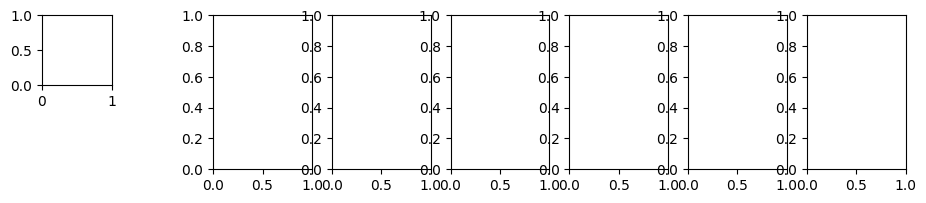

In [19]:
# This part for model interpretation 

# 1. Visualise Filters
import matplotlib.pyplot as plt

filters = autoencoder.layers[1].get_weights()[0]

# Assuming the filters are 3D
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 8
fig, axes = plt.subplots(1, n_filters, figsize=(12,2))
axes = axes.ravel()

for i in range(n_filters):
    f = filters[:, :, :, i]
    plt.subplot(2, 4, i+1)
    plt.imshow(f[:, :, 0], cmap='gray')  # Adjust the last index if needed
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# 2. Visualizing Activations

from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Select a sample from your dataset
sample = X_train_padded[10]
sample = np.expand_dims(sample, axis=0)

# Define a model to fetch activations
activations_model = Model(inputs=autoencoder.input, outputs=[layer.output for layer in autoencoder.layers])
activations = activations_model.predict(sample)

# Visualize activations of the first convolutional layer
first_layer_activations = activations[1]
n_filters = first_layer_activations.shape[-1]

for i in range(n_filters):
    plt.subplot(2, 4, i+1)
    plt.imshow(first_layer_activations[0, :, :, i], cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
# 3. Visualizing Encoded Representations

encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
encoded_representation = encoder_model.predict(sample)

plt.imshow(encoded_representation[0, :, :, 0], cmap='gray')  # Adjust indices as needed
plt.title('Encoded Representation')
plt.axis('off')
plt.show()


In [ ]:
# 4. Dimensionality Reduction on Encoded Representations (Optional)

from sklearn.manifold import TSNE
import seaborn as sns

# Assuming `encoded_data` contains encoded representations of your entire dataset
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_data.reshape(len(encoded_data), -1))

sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], alpha=0.5)
plt.title('t-SNE of Encoded Representations')
plt.show()


In [ ]:
# Evaluation Part Below


In [ ]:
# 1. Reconstruction Error:Evaluate how well the autoencoder can reconstruct the input data

from sklearn.metrics import mean_squared_error, mean_absolute_error

decoded_val = autoencoder.predict(X_val_padded)

# Mean Squared Error (MSE)
mse = mean_squared_error(X_val_padded.flatten(), decoded_val.flatten())

# Mean Absolute Error (MAE)
mae = mean_absolute_error(X_val_padded.flatten(), decoded_val.flatten())

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


In [ ]:
# 2. Visual Inspection of Reconstructions:

import matplotlib.pyplot as plt
import numpy as np

index = np.random.randint(X_val_padded.shape[0])
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(X_val_padded[index, :, :, 0], cmap='gray')  # Adjust indexing if necessary
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(decoded_val[index, :, :, 0], cmap='gray')
plt.title('Reconstructed')

plt.show()


In [ ]:
# 3. Latent Space Visualization:

from sklearn.manifold import TSNE
import seaborn as sns

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
encoded_data = encoder.predict(X_val_padded)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_data.reshape(len(encoded_data), -1))

sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE of Encoded Representations')
plt.show()
